In [ ]:
!pip -q install datasets sentence-transformers faiss-cpu python-dateutil pandas nltk scikit-learn torch tqdm transformers


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 80.0 MB/s eta 0:00:00


In [ ]:
import re, random, numpy as np, pandas as pd
from tqdm import tqdm
from datetime import timezone
from dateutil import parser as dtp

import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

import faiss
from datasets import load_dataset, Dataset
from sentence_transformers import SentenceTransformer, models, losses, InputExample, SentencesDataset

import nltk
nltk.download("punkt")
from nltk.tokenize import sent_tokenize

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

def normalize_date(d):
    if not d: return None
    try: return dtp.parse(d).astimezone(timezone.utc).date().isoformat()
    except: return None


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
print("Loading 'HuggingFaceFW/fineweb' dataset...")

# knobs
N_DOCS     = 20000          # raw docs to stream
BUF_SIZE   = 50000          # shuffle buffer
LOG_EVERY  = 1000
CHUNK_MAX_WORDS = 160
CHUNK_MIN_WORDS = 60

stream = (load_dataset(
            "HuggingFaceFW/fineweb",
            name="sample-10BT",
            split="train",
            streaming=True
         )
         .shuffle(seed=SEED, buffer_size=BUF_SIZE)
         .take(N_DOCS))

docs = []
for i, ex in enumerate(stream, 1):
    if i % LOG_EVERY == 0:
        print(f"[stream] {i}/{N_DOCS}")
    if not ex.get("text") or not ex.get("date"):
        continue
    docs.append({
        "text": ex["text"],
        "timestamp": normalize_date(ex["date"]),
        "source": ex.get("source",""),
        "url": ex.get("url","")
    })

ds = Dataset.from_list(docs)
print(ds)
print(ds[0])


Loading 'HuggingFaceFW/fineweb' dataset...


README.md: 0.00B [00:00, ?B/s]

Resolving data files:   0%|          | 0/27468 [00:00<?, ?it/s]

[stream] 1000/20000
[stream] 2000/20000
[stream] 3000/20000
[stream] 4000/20000
[stream] 5000/20000
[stream] 6000/20000
[stream] 7000/20000
[stream] 8000/20000
[stream] 9000/20000
[stream] 10000/20000
[stream] 11000/20000
[stream] 12000/20000
[stream] 13000/20000
[stream] 14000/20000
[stream] 15000/20000
[stream] 16000/20000
[stream] 17000/20000
[stream] 18000/20000
[stream] 19000/20000
[stream] 20000/20000
Dataset({
    features: ['text', 'timestamp', 'source', 'url'],
    num_rows: 20000
})
{'text': 'Sherri Shepherd is taking “The View” to church. The newlywed co-host of the daytime talkfest created by Barbara Walters will undoubtedly be a large part of today’s Gospel Brunch program which includes The Kings Men – Marvin Sapp, Donnie McClurkin and Israel Houghton and Kirk Franklin – and soul food chef Melba Wilson. The Kings Men begin their tour in September. For tickets and information click here.\nShepherd and TV writer Lamar Sally celebrate their first anniversary next month. She t

In [ ]:
def chunk_text_sents(text, max_words=CHUNK_MAX_WORDS, min_words=CHUNK_MIN_WORDS):
    chunks, cur, n = [], [], 0
    for s in sent_tokenize(text):
        w = s.split()
        if n + len(w) > max_words and cur:
            ch = ' '.join(cur).strip()
            if len(ch.split()) >= min_words:
                chunks.append(ch)
            cur, n = [], 0
        cur += w; n += len(w)
    if cur:
        ch = ' '.join(cur).strip()
        if len(ch.split()) >= min_words:
            chunks.append(ch)
    return chunks

import nltk

nltk.download('punkt')
nltk.download('punkt_tab')


records = []
for ex in tqdm(ds, desc="Chunking"):
    ts = ex["timestamp"]
    if not ts:
        continue
    text = (ex["text"] or "").strip()
    if not text:
        continue
    for ch in chunk_text_sents(text):
        records.append({"passage": ch, "timestamp": ts, "source": ex["source"], "url": ex["url"]})

corpus_df = pd.DataFrame(records)
corpus_df.reset_index(inplace=True, drop=False)
corpus_df.rename(columns={"index":"passage_id"}, inplace=True)
print(f"Docs: {len(ds)} | Passages: {len(corpus_df)}")
corpus_df.head(2)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
Chunking: 100%|██████████| 20000/20000 [00:14<00:00, 1373.97it/s]


Docs: 20000 | Passages: 72172


,passage_id,passage,timestamp,source,url
0,0,Sherri Shepherd is taking “The View” to church...,2014-08-20,,http://blackamericaweb.com/2012/07/24/tjms-int...
1,1,- Top PR Firm - Email Newsletters - Pro Bono -...,2015-08-29,,http://mediafirst.net/digital-marketing-agency...


In [ ]:
train_df, test_df = train_test_split(corpus_df, test_size=0.2, random_state=SEED)
print(f"Train passages: {len(train_df)} | Test passages: {len(test_df)}")


Train passages: 57737 | Test passages: 14435


In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# A solid, lightweight QG model that supports <hl> highlighting
QG_MODEL = "valhalla/t5-base-qg-hl"
qg_tok   = AutoTokenizer.from_pretrained(QG_MODEL)
qg       = AutoModelForSeq2SeqLM.from_pretrained(QG_MODEL).to("cuda" if torch.cuda.is_available() else "cpu")

def qg_from_passage(passage, iso_date, max_new_tokens=64):
    # highlight one answer sentence to guide QG
    sents = sent_tokenize(passage)
    # pick a mid-length sentence to highlight
    sents_sorted = sorted(sents, key=lambda s: abs(len(s)-120))
    ans = sents_sorted[0] if sents_sorted else sents[:1]
    highlighted = passage.replace(ans, f"<hl> {ans} <hl>", 1)
    prompt = f"generate question: {highlighted}"
    inputs = qg_tok(prompt, return_tensors="pt", truncation=True, max_length=512).to(qg.device)
    out = qg.generate(**inputs, max_new_tokens=max_new_tokens, num_beams=4)
    question = qg_tok.decode(out[0], skip_special_tokens=True)
    # inject temporal anchor cleanly
    return f"As of {iso_date}, {question}"

def build_qg_set(df, n_queries):
    idxs = np.random.choice(df.index.values, size=min(n_queries, len(df)), replace=False)
    queries = []
    for i in tqdm(idxs, desc="QG"):
        p = df.loc[i, "passage"]
        t = df.loc[i, "timestamp"]
        q = qg_from_passage(p, t)
        queries.append({"query": q, "gold_id": int(df.loc[i,"passage_id"]), "q_time": t})
    return queries

# how many questions
N_TRAIN_Q = min(3000, len(train_df))
N_TEST_Q  = min(1200, len(test_df))

train_queries = build_qg_set(train_df, N_TRAIN_Q)
test_queries  = build_qg_set(test_df,  N_TEST_Q)

len(train_queries), len(test_queries)


tokenizer_config.json:   0%|          | 0.00/129 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/15.0 [00:00<?, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


pytorch_model.bin:   0%|          | 0.00/892M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]


QG: 100%|██████████| 1200/1200 [06:47<00:00,  2.94it/s]


(3000, 1200)

In [ ]:
BASE_MODEL = "sentence-transformers/all-MiniLM-L6-v2"
base_qp = SentenceTransformer(BASE_MODEL)   # used for both queries and passages in baseline

def encode_texts(model, texts, batch=256):
    embs = []
    for i in tqdm(range(0, len(texts), batch), desc="Encoding"):
        e = model.encode(texts[i:i+batch], normalize_embeddings=True, convert_to_numpy=True, batch_size=min(batch,64))
        embs.append(e.astype(np.float32))
    return np.vstack(embs) if embs else np.zeros((0,384), dtype=np.float32)

def build_index_cosine(embs):
    idx = faiss.IndexFlatIP(embs.shape[1])
    idx.add(embs)
    return idx

def recall_at_k(topk_ids, gold_ids, k=5):
    return float(np.mean([1.0 if gid in ids[:k] else 0.0 for ids,gid in zip(topk_ids, gold_ids)]))

# Big index over the WHOLE corpus (not just test)
all_passages = corpus_df["passage"].tolist()
all_emb_base = encode_texts(base_qp, all_passages)
index_all_base = build_index_cosine(all_emb_base)

# encode test queries and search against the big index
Q_texts  = [q["query"] for q in test_queries]
gold_ids = [q["gold_id"] for q in test_queries]
q_emb_base = encode_texts(base_qp, Q_texts)

K = 5
topk_base = []
for qv in tqdm(q_emb_base, desc="Search baseline (BIG index)"):
    D, I = index_all_base.search(qv.reshape(1,-1), K)
    mapped = [int(corpus_df.iloc[idx].passage_id) for idx in I[0]]  # row→passage_id
    topk_base.append(mapped)

rec_base = recall_at_k(topk_base, gold_ids, k=K)
print(f"[BIG] Baseline Recall@{K}: {rec_base:.3f}")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Search baseline (BIG index): 100%|██████████| 1200/1200 [00:10<00:00, 117.09it/s]

[BIG] Baseline Recall@5: 0.646


In [ ]:
# Build TRAIN-only index for mining
train_passages = train_df["passage"].tolist()
train_emb_base = encode_texts(base_qp, train_passages)
index_train = build_index_cosine(train_emb_base)

def parse_year(iso):
    try: return int(iso[:4])
    except: return None

SEM_THRESHOLD = 0.45
POOL_K       = 200

tn_pairs = []  # (query, pos_passage, neg_passage)
id2row = {int(r.passage_id): j for j, r in train_df.reset_index().iterrows()}

for q in tqdm(train_queries, desc="Mining temporal negatives"):
    gid = q["gold_id"]
    if gid not in id2row:
        continue
    pos_row = train_df.iloc[id2row[gid]]
    pos_year = parse_year(pos_row.timestamp)

    qv = base_qp.encode([q["query"]], normalize_embeddings=True, convert_to_numpy=True).astype(np.float32)
    D, I = index_train.search(qv, POOL_K)

    neg = None
    for s, idx in zip(D[0], I[0]):
        cand = train_df.iloc[idx]
        if int(cand.passage_id) == gid: continue
        if parse_year(cand.timestamp) == pos_year: continue   # require different year
        if float(s) < SEM_THRESHOLD: continue                 # require semantic overlap
        neg = cand.passage; break

    if neg:
        tn_pairs.append((q["query"], pos_row.passage, neg))

len(tn_pairs)


Mining temporal negatives: 100%|██████████| 3000/3000 [00:47<00:00, 62.96it/s]


2256

In [ ]:
# Initialize from the same base model for apples-to-apples
word = models.Transformer(BASE_MODEL)
pool = models.Pooling(word.get_word_embedding_dimension(), pooling_mode_mean_tokens=True)
time_model = SentenceTransformer(modules=[word, pool])

import os
os.environ["WANDB_MODE"] = "disabled"
os.environ["WANDB_DISABLED"] = "true"  # catch-all for older versions
os.environ["TRANSFORMERS_NO_ADVISORY_WARNINGS"] = "1"
os.environ["HF_HUB_DISABLE_TELEMETRY"] = "1"


train_samples = []
for q, pos, neg in tn_pairs:
    train_samples.append(InputExample(texts=[q, pos], label=1.0))
    train_samples.append(InputExample(texts=[q, neg], label=0.0))

train_dataset = SentencesDataset(train_samples, time_model)
train_loader  = DataLoader(train_dataset, shuffle=True, batch_size=64)
loss_fn = losses.CosineSimilarityLoss(model=time_model)

EPOCHS = 1  # bump if you have GPU time
time_model.fit(
    train_objectives=[(train_loader, loss_fn)],
    epochs=EPOCHS,
    warmup_steps=min(1000, max(10, len(train_loader)//10)),
    show_progress_bar=True
    )

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss


In [ ]:
# Re-encode the WHOLE corpus with the time-aware model
all_emb_time = encode_texts(time_model, all_passages)
index_all_time = build_index_cosine(all_emb_time)

# Encode test queries with the time-aware model
q_emb_time = encode_texts(time_model, Q_texts)

topk_time = []
for qv in tqdm(q_emb_time, desc="Search time-aware (BIG index)"):
    D, I = index_all_time.search(qv.reshape(1,-1), K)
    mapped = [int(corpus_df.iloc[idx].passage_id) for idx in I[0]]
    topk_time.append(mapped)

rec_time = recall_at_k(topk_time, gold_ids, k=K)
print(f"[BIG] Time-aware Recall@{K}: {rec_time:.3f}   Δ={rec_time - rec_base:+.3f}")


Search time-aware (BIG index): 100%|██████████| 1200/1200 [00:10<00:00, 116.97it/s]

[BIG] Time-aware Recall@5: 0.749   Δ=+0.103


In [ ]:
# === Build a larger, more realistic conflict set ===
import re

def normalize_topic(text):
    toks = re.findall(r"[A-Za-z][A-Za-z\-]{2,}", text.lower())
    keep = [t for t in toks if t not in {"the","and","for","with","from","that","this","have","has","are","was","were"}]
    return tuple(sorted(keep[:12]))  # coarser but better grouping

corpus_df["topic_key"] = corpus_df["passage"].map(normalize_topic)

def year_of(iso):
    try: return int(iso[:4])
    except: return None

grp = corpus_df.groupby("topic_key")["timestamp"].apply(list)
conflict_rows = []
for k, ts in grp.items():
    years = {year_of(t) for t in ts if t}
    if len([y for y in years if y is not None]) >= 2:
        conflict_rows.extend(corpus_df.index[corpus_df["topic_key"] == k].tolist())

eval_df = corpus_df.loc[conflict_rows].sample(n=min(2000, len(conflict_rows)), random_state=42).reset_index(drop=True)
print("Conflict rows:", len(eval_df))


Conflict rows: 57


In [ ]:
from dateutil import parser as dtp
import numpy as np

def recall_at_k(topk_ids, gold_ids, k=1):
    return float(np.mean([1.0 if gid in ids[:k] else 0.0 for ids,gid in zip(topk_ids, gold_ids)]))

def acc_within_days(top1_ids, q_times, df_eval, days=365):
    ok = 0
    for pid, qt in zip(top1_ids, q_times):
        row = df_eval.loc[df_eval.passage_id == pid].iloc[0]
        ok += int(abs((dtp.parse(qt).date() - dtp.parse(row.timestamp).date()).days) <= days)
    return ok / len(q_times)

r1_base  = recall_at_k(topk_base, gold_ids, k=1)
r1_time  = recall_at_k(topk_time, gold_ids, k=1)
tc1_base = acc_within_days([ids[0] for ids in topk_base], [q["q_time"] for q in test_queries], corpus_df, days=365)
tc1_time = acc_within_days([ids[0] for ids in topk_time], [q["q_time"] for q in test_queries], corpus_df, days=365)

print(f"[BIG] R@1 base={r1_base:.3f} time={r1_time:.3f}  |  TC@1(≤1y) base={tc1_base:.3f} time={tc1_time:.3f}")


[BIG] R@1 base=0.458 time=0.532  |  TC@1(≤1y) base=0.679 time=0.737


In [ ]:
# Build test queries from the conflict set using QG
N_TEST_Q_CONFLICT = min(1200, len(eval_df))
test_queries_conf = []
idxs = np.random.choice(eval_df.index.values, size=N_TEST_Q_CONFLICT, replace=False)
for i in tqdm(idxs, desc="QG (conflict)"):
    p = eval_df.loc[i, "passage"]; t = eval_df.loc[i, "timestamp"]
    q = qg_from_passage(p, t)
    test_queries_conf.append({"query": q, "gold_id": int(eval_df.loc[i,"passage_id"]), "q_time": t})

# Encode queries with both models
Q_conf = [q["query"] for q in test_queries_conf]
G_conf = [q["gold_id"] for q in test_queries_conf]

q_emb_base_c = encode_texts(base_qp, Q_conf)
q_emb_time_c = encode_texts(time_model, Q_conf)

# Build conflict-only index (use eval_df rows)
pass_eval = eval_df["passage"].tolist()
emb_eval_base = encode_texts(base_qp, pass_eval)
emb_eval_time = encode_texts(time_model, pass_eval)
idx_eval_base = build_index_cosine(emb_eval_base)
idx_eval_time = build_index_cosine(emb_eval_time)

def search_map(index, df_eval, q_emb):
    out = []
    for qv in q_emb:
        D, I = index.search(qv.reshape(1,-1), K)
        mapped = [int(df_eval.iloc[idx].passage_id) for idx in I[0]]
        out.append(mapped)
    return out

topk_base_c = search_map(idx_eval_base, eval_df, q_emb_base_c)
topk_time_c = search_map(idx_eval_time, eval_df, q_emb_time_c)

r5_base_c = recall_at_k(topk_base_c, G_conf, k=K)
r5_time_c = recall_at_k(topk_time_c, G_conf, k=K)
print(f"[CONFLICT] Baseline R@{K}={r5_base_c:.3f}  Time-aware R@{K}={r5_time_c:.3f}  Δ={r5_time_c-r5_base_c:+.3f}")


Encoding: 100%|██████████| 1/1 [00:00<00:00, 13.44it/s]

[CONFLICT] Baseline R@5=0.772  Time-aware R@5=0.912  Δ=+0.140


In [ ]:
def show_flip(i, df_eval, topk_b, topk_t, queries, K=5):
    q = queries[i]
    print("\n———")
    print("Q:", q["query"])
    print("Gold:", q["gold_id"], q["q_time"])

    print("\nBaseline top-3:")
    for r, pid in enumerate(topk_b[i][:3], 1):
        row = df_eval.loc[df_eval.passage_id == pid].iloc[0]
        print(f"{r}. id={int(row.passage_id)} time={row.timestamp}")
        print("   ", (row.passage[:160] + " ...").replace("\n"," "))

    print("\nTime-aware top-3:")
    for r, pid in enumerate(topk_t[i][:3], 1):
        row = df_eval.loc[df_eval.passage_id == pid].iloc[0]
        print(f"{r}. id={int(row.passage_id)} time={row.timestamp}")
        print("   ", (row.passage[:160] + " ...").replace("\n"," "))

flips = []
for i, q in enumerate(test_queries_conf):
    gid = q["gold_id"]
    if (gid not in topk_base_c[i][:K]) and (gid in topk_time_c[i][:K]):
        flips.append(i)

for i in flips[:5]:
    show_flip(i, eval_df, topk_base_c, topk_time_c, test_queries_conf)
if not flips:
    print("No flips in this run — increase N_DOCS/N_TEST_Q_CONFLICT or EPOCHS.")



———
Q: As of 2018-01-20, What is the first thing that you can do without switching to a different company?
Gold: 68931 2018-01-20

Baseline top-3:
1. id=54115 time=2014-08-29
    Thank you for reading the MtDemocrat.com digital edition. In order to continue reading this story please choose one of the following options. If you are a curre ...
2. id=71758 time=2015-09-04
    Thank you for reading the MtDemocrat.com digital edition. In order to continue reading this story please choose one of the following options. If you are a curre ...
3. id=51663 time=2020-01-20
    This shop has been compensated by Collective Bias, Inc. and its advertiser. All opinions are mine alone. Truth: I’m at that stage where I am dying my roots to c ...

Time-aware top-3:
1. id=7396 time=2018-01-22
    Create an Account - Increase your productivity, customize your experience, and engage in information you care about. Show All Answers Refrain from mowing, if po ...
2. id=68931 time=2018-01-20
    It can be very

In [ ]:
# == CC-News EVAL: stream, chunk, query, evaluate ==
import re, random, numpy as np, pandas as pd
from tqdm import tqdm
from datasets import load_dataset
from dateutil import parser as dtp
from datetime import timezone

SEED = 42
random.seed(SEED); np.random.seed(SEED)

# knobs
N_DOCS_EVAL = 25000     # increase if you want
BUF_SIZE     = 50000
CHUNK_MAX    = 160
CHUNK_MIN    = 60
N_TEST_Q     = 1500
K            = 5

# fallbacks if not defined above
try:
    sent_tokenize
except NameError:
    def sent_tokenize(text): return re.split(r'(?<=[.!?])\s+', text)

def normalize_date(d):
    if not d: return None
    try: return dtp.parse(d).astimezone(timezone.utc).date().isoformat()
    except:
        try: return dtp.parse(str(d)).date().isoformat()
        except: return None

def chunk_text_sents(text, max_words=CHUNK_MAX, min_words=CHUNK_MIN):
    chunks, cur, n = [], [], 0
    for s in sent_tokenize(text):
        w = s.split()
        if n + len(w) > max_words and cur:
            ch = ' '.join(cur).strip()
            if len(ch.split()) >= min_words: chunks.append(ch)
            cur, n = [], 0
        cur += w; n += len(w)
    if cur:
        ch = ' '.join(cur).strip()
        if len(ch.split()) >= min_words: chunks.append(ch)
    return chunks

try:
    encode_texts, build_index_cosine
except NameError:
    from sentence_transformers import SentenceTransformer
    import faiss
    def encode_texts(model, texts, batch=256):
        out = []
        for i in tqdm(range(0, len(texts), batch), desc="Encoding"):
            emb = model.encode(texts[i:i+batch], normalize_embeddings=True,
                               convert_to_numpy=True, batch_size=min(batch,64))
            out.append(emb.astype(np.float32))
        return np.vstack(out) if out else np.zeros((0,384), dtype=np.float32)
    def build_index_cosine(embs):
        idx = faiss.IndexFlatIP(embs.shape[1]); idx.add(embs); return idx

def recall_at_k(topk_ids, gold_ids, k=1):
    return float(np.mean([1.0 if gid in ids[:k] else 0.0 for ids,gid in zip(topk_ids, gold_ids)]))

def acc_within_days(top1_ids, q_times, df_eval, days=365):
    ok = 0
    for pid, qt in zip(top1_ids, q_times):
        row = df_eval.loc[df_eval.passage_id==pid]
        if row.empty: continue
        row = row.iloc[0]
        try:
            ok += int(abs((dtp.parse(qt).date() - dtp.parse(row.timestamp).date()).days) <= days)
        except: pass
    return ok / len(q_times)

# 1) Stream CC-News and build passages
stream = (load_dataset("cc_news", split="train", streaming=True)
          .shuffle(seed=SEED, buffer_size=BUF_SIZE)
          .take(N_DOCS_EVAL))

records = []
for ex in tqdm(stream, total=N_DOCS_EVAL, desc="Streaming CC-News"):
    text = (ex.get("text") or "").strip()
    ts   = normalize_date(ex.get("date"))
    if not text or not ts: continue
    for ch in chunk_text_sents(text):
        records.append({"passage": ch, "timestamp": ts})

cc_df = pd.DataFrame(records).reset_index().rename(columns={"index":"passage_id"})
print(f"CC-News passages: {len(cc_df)}")

# 2) Build queries (use your QG if present, else lightweight template)
def pick_mid_sentence(p):
    s = sent_tokenize(p)
    if not s: return p
    return sorted(s, key=lambda x: abs(len(x)-120))[0]

def default_query(passage, iso_date):
    s = pick_mid_sentence(passage)
    toks = re.findall(r"[A-Za-z]\w+", s.lower())
    stops = set("the a an and or but if while with of for in on at by to from as is are was were this that these those it its their his her they them you we our your not no".split())
    cands = [t for t in toks if t not in stops and len(t)>2][:6]
    hint = " ".join(cands) if cands else s[:80]
    return f"As of {iso_date}, what does the passage say about {hint}?"

use_qg = 'qg' in globals() and 'qg_tok' in globals()
def make_query(p, t):
    if use_qg:
        s = pick_mid_sentence(p)
        highlighted = p.replace(s, f"<hl> {s} <hl>", 1)
        prompt = f"generate question: {highlighted}"
        inputs = qg_tok(prompt, return_tensors="pt", truncation=True, max_length=512).to(qg.device)
        out = qg.generate(**inputs, max_new_tokens=64, num_beams=4)
        q = qg_tok.decode(out[0], skip_special_tokens=True)
        return f"As of {t}, {q}"
    else:
        return default_query(p, t)

idxs = np.random.choice(cc_df.index.values, size=min(N_TEST_Q, len(cc_df)), replace=False)
eval_queries = [{"query": make_query(cc_df.loc[i,"passage"], cc_df.loc[i,"timestamp"]),
                 "q_time": cc_df.loc[i,"timestamp"], "gold_id": int(cc_df.loc[i,"passage_id"])}
                for i in tqdm(idxs, desc="Building queries")]

Q_texts  = [q["query"] for q in eval_queries]
G_ids    = [q["gold_id"] for q in eval_queries]
Q_times  = [q["q_time"] for q in eval_queries]

# 3) Evaluate both models
from sentence_transformers import SentenceTransformer
try:
    base_qp
except NameError:
    base_qp = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
try:
    time_model
except NameError:
    time_model = base_qp  # placeholder if you didn't load your fine-tuned one

def eval_model(model, title):
    all_passages = cc_df["passage"].tolist()
    embs = encode_texts(model, all_passages)
    idx  = build_index_cosine(embs)
    qemb = encode_texts(model, Q_texts)

    topk = []
    for v in tqdm(qemb, desc=f"Search {title}"):
        D, I = idx.search(v.reshape(1,-1), K)
        mapped = [int(cc_df.iloc[j].passage_id) for j in I[0]]
        topk.append(mapped)

    r1 = recall_at_k(topk, G_ids, k=1)
    r5 = recall_at_k(topk, G_ids, k=5)
    tc = acc_within_days([t[0] for t in topk], Q_times, cc_df, days=365)
    print(f"[{title}] R@1={r1:.3f}  R@5={r5:.3f}  TC@1(≤1y)={tc:.3f}")
    return topk, (r1,r5,tc)

topk_base, m_base = eval_model(base_qp, "Baseline")
topk_time, m_time = eval_model(time_model, "Time-aware")

print("\n=== CC-News SUMMARY ===")
print(f"Baseline   R@1={m_base[0]:.3f}  R@5={m_base[1]:.3f}  TC@1={m_base[2]:.3f}")
print(f"Time-aware R@1={m_time[0]:.3f}  R@5={m_time[1]:.3f}  TC@1={m_time[2]:.3f}  "
      f"ΔR@1={m_time[0]-m_base[0]:+.3f}  ΔR@5={m_time[1]-m_base[1]:+.3f}  ΔTC@1={m_time[2]-m_base[2]:+.3f}")


README.md: 0.00B [00:00, ?B/s]

Streaming CC-News: 100%|██████████| 25000/25000 [00:28<00:00, 881.57it/s] 


CC-News passages: 53262


Search Baseline: 100%|██████████| 1500/1500 [00:09<00:00, 157.42it/s]


[Baseline] R@1=0.405  R@5=0.659  TC@1(≤1y)=0.958


Search Time-aware: 100%|██████████| 1500/1500 [00:09<00:00, 162.82it/s]


[Time-aware] R@1=0.514  R@5=0.772  TC@1(≤1y)=0.963

=== CC-News SUMMARY ===
Baseline   R@1=0.405  R@5=0.659  TC@1=0.958
Time-aware R@1=0.514  R@5=0.772  TC@1=0.963  ΔR@1=+0.109  ΔR@5=+0.113  ΔTC@1=+0.005


In [ ]:
# == Conflict-only subset on CC-News: group by coarse topic, keep topics with ≥2 years ==
import re
def topic_key(text):
    toks = re.findall(r"[A-Za-z][A-Za-z\-]{2,}", text.lower())
    stops = set("the a an and or but if while with of for in on at by to from as is are was were this that these those it its their his her they them you we our your not no".split())
    keep = [t for t in toks if t not in stops][:12]
    return tuple(sorted(keep[:8]))

cc_df["topic_key"] = cc_df["passage"].map(topic_key)
def year_of(iso):
    try: return int(iso[:4])
    except: return None

grp = cc_df.groupby("topic_key")["timestamp"].apply(list)
conflict_idxs = []
for key, ts in grp.items():
    years = {year_of(t) for t in ts if t}
    if len([y for y in years if y is not None]) >= 2:
        conflict_idxs.extend(cc_df.index[cc_df["topic_key"]==key].tolist())

conf_df = cc_df.loc[conflict_idxs].reset_index(drop=True)
print("Conflict passages:", len(conf_df))

# build queries from conflict set
M = min(1000, len(conf_df))
sel = np.random.choice(conf_df.index.values, size=M, replace=False)
conf_qs = [{"query": make_query(conf_df.loc[i,"passage"], conf_df.loc[i,"timestamp"]),
            "q_time": conf_df.loc[i,"timestamp"],
            "gold_id": int(conf_df.loc[i,"passage_id"])} for i in sel]

Q_c = [x["query"] for x in conf_qs]
G_c = [x["gold_id"] for x in conf_qs]
T_c = [x["q_time"] for x in conf_qs]

# encode & index conflict-only
def search_eval(model, df, Q, G, T, title):
    embs = encode_texts(model, df["passage"].tolist())
    idx  = build_index_cosine(embs)
    qemb = encode_texts(model, Q)

    topk = []
    for v in tqdm(qemb, desc=f"Search {title} (conflict)"):
        D, I = idx.search(v.reshape(1,-1), 5)
        mapped = [int(df.iloc[j].passage_id) for j in I[0]]
        topk.append(mapped)

    r1 = recall_at_k(topk, G, k=1)
    r5 = recall_at_k(topk, G, k=5)
    tc = acc_within_days([t[0] for t in topk], T, df, days=365)
    print(f"[{title} | conflict] R@1={r1:.3f}  R@5={r5:.3f}  TC@1={tc:.3f}")
    return r1, r5, tc

r1b, r5b, tcb = search_eval(base_qp,  conf_df, Q_c, G_c, T_c, "Baseline")
r1t, r5t, tct = search_eval(time_model, conf_df, Q_c, G_c, T_c, "Time-aware")
print(f"Δ (Time-aware − Baseline): ΔR@1={r1t-r1b:+.3f}  ΔR@5={r5t-r5b:+.3f}  ΔTC@1={tct-tcb:+.3f}")


Conflict passages: 1396


Search Baseline (conflict): 100%|██████████| 1000/1000 [00:00<00:00, 2772.26it/s]


[Baseline | conflict] R@1=0.539  R@5=0.684  TC@1=0.974


Search Time-aware (conflict): 100%|██████████| 1000/1000 [00:00<00:00, 2739.33it/s]


[Time-aware | conflict] R@1=0.603  R@5=0.736  TC@1=0.953
Δ (Time-aware − Baseline): ΔR@1=+0.064  ΔR@5=+0.052  ΔTC@1=-0.021


In [ ]:
# == Bootstrap 95% CIs for R@1 ==
import numpy as np

def r1_array(topk, gold, k=1):
    return np.array([1 if g in ids[:k] else 0 for ids,g in zip(topk, gold)], dtype=np.float32)

r1_base_vec = r1_array(*eval(f"topk_base, G_ids"), k=1)
r1_time_vec = r1_array(*eval(f"topk_time, G_ids"), k=1)

def bootstrap_ci(vec, nboot=200, alpha=0.05):
    n = len(vec); stats = []
    for _ in range(nboot):
        idx = np.random.randint(0, n, size=n)
        stats.append(vec[idx].mean())
    lo = np.percentile(stats, 100*alpha/2)
    hi = np.percentile(stats, 100*(1-alpha/2))
    return float(lo), float(hi)

lo_b, hi_b = bootstrap_ci(r1_base_vec)
lo_t, hi_t = bootstrap_ci(r1_time_vec)
print(f"R@1 Baseline 95% CI: [{lo_b:.3f}, {hi_b:.3f}]")
print(f"R@1 Time-aware 95% CI: [{lo_t:.3f}, {hi_t:.3f}]")
print(f"ΔR@1 point estimate: {r1_time_vec.mean()-r1_base_vec.mean():+.3f}")


R@1 Baseline 95% CI: [0.383, 0.431]
R@1 Time-aware 95% CI: [0.485, 0.535]
ΔR@1 point estimate: +0.109


In [ ]:
# === Post-analysis on CC-News run you already executed ===
# Uses: cc_df, eval_queries (Q_texts, G_ids, Q_times), topk_base, topk_time

import numpy as np, pandas as pd
from dateutil import parser as dtp
from collections import defaultdict
from tqdm import tqdm

def recall_at_k(topk_ids, gold_ids, k=1):
    return float(np.mean([1.0 if gid in ids[:k] else 0.0 for ids,gid in zip(topk_ids, gold_ids)]))

def r_at_k_vec(topk_ids, gold_ids, k=1):
    return np.array([1 if gid in ids[:k] else 0 for ids,gid in zip(topk_ids, gold_ids)], dtype=np.float32)

def top1_temporal_error_days(top1_ids, q_times, df):
    errs = []
    for pid, qt in zip(top1_ids, q_times):
        row = df.loc[df.passage_id == pid]
        if row.empty:
            continue
        pd_ts = row.iloc[0].timestamp
        try:
            d = abs((dtp.parse(qt).date() - dtp.parse(pd_ts).date()).days)
            errs.append(d)
        except Exception:
            pass
    return np.array(errs, dtype=np.float32)

def bootstrap_ci(vec, nboot=400, alpha=0.05):
    n = len(vec)
    if n == 0: return (np.nan, np.nan)
    stats = []
    for _ in range(nboot):
        idx = np.random.randint(0, n, size=n)
        stats.append(vec[idx].mean())
    lo = float(np.percentile(stats, 100*alpha/2))
    hi = float(np.percentile(stats, 100*(1-alpha/2)))
    return lo, hi

# 1) Per-year R@1
def year_of(iso):
    try: return int(iso[:4])
    except: return None

years = [year_of(t) for t in Q_times]
r1_base_vec = r_at_k_vec(topk_base, G_ids, k=1)
r1_time_vec = r_at_k_vec(topk_time, G_ids, k=1)

by_year = defaultdict(lambda: {"base": [], "time": []})
for y, b, t in zip(years, r1_base_vec, r1_time_vec):
    if y is not None:
        by_year[y]["base"].append(b)
        by_year[y]["time"].append(t)

rows = []
for y in sorted(by_year.keys()):
    base_vals = np.array(by_year[y]["base"], dtype=np.float32)
    time_vals = np.array(by_year[y]["time"], dtype=np.float32)
    if len(base_vals) < 20:  # skip tiny bins
        continue
    rows.append({
        "year": y,
        "R@1_base": base_vals.mean(),
        "R@1_time": time_vals.mean(),
        "ΔR@1": time_vals.mean() - base_vals.mean(),
        "n": len(base_vals),
    })

per_year_df = pd.DataFrame(rows).sort_values("year")
print("Per-year R@1 (skip bins with n<20):")
display(per_year_df)

# 2) Temporal error (days) @ top-1
top1_base = [ids[0] for ids in topk_base]
top1_time = [ids[0] for ids in topk_time]

err_base = top1_temporal_error_days(top1_base, Q_times, cc_df)
err_time = top1_temporal_error_days(top1_time, Q_times, cc_df)

def summarize_err(name, arr):
    if len(arr)==0:
        print(f"{name}: no data")
        return
    print(f"{name}: MAE={np.mean(arr):.1f} days | MedianAE={np.median(arr):.1f} | 90th={np.percentile(arr,90):.1f} | n={len(arr)}")
summarize_err("Temporal error@1 (Baseline)", err_base)
summarize_err("Temporal error@1 (Time-aware)", err_time)

# 3) Bootstrap CIs for R@1, R@5, and deltas
r5_base_vec = r_at_k_vec(topk_base, G_ids, k=5)
r5_time_vec = r_at_k_vec(topk_time, G_ids, k=5)

def print_ci(name, vec):
    lo, hi = bootstrap_ci(vec)
    print(f"{name}: mean={vec.mean():.3f}  95% CI=[{lo:.3f}, {hi:.3f}]  n={len(vec)}")

print("\nBootstrap 95% CIs:")
print_ci("R@1 Base", r1_base_vec)
print_ci("R@1 Time", r1_time_vec)
print_ci("R@5 Base", r5_base_vec)
print_ci("R@5 Time", r5_time_vec)

# For deltas, bootstrap paired differences
def paired_bootstrap_ci(a, b, nboot=400, alpha=0.05):
    n = len(a); diffs = []
    for _ in range(nboot):
        idx = np.random.randint(0, n, size=n)
        diffs.append((b[idx] - a[idx]).mean())
    diffs = np.array(diffs)
    lo = float(np.percentile(diffs, 100*alpha/2))
    hi = float(np.percentile(diffs, 100*(1-alpha/2)))
    return (float(diffs.mean()), lo, hi)

d_r1_mean, d_r1_lo, d_r1_hi = paired_bootstrap_ci(r1_base_vec, r1_time_vec)
d_r5_mean, d_r5_lo, d_r5_hi = paired_bootstrap_ci(r5_base_vec, r5_time_vec)
print(f"\nΔR@1 mean={d_r1_mean:+.3f}  95% CI=[{d_r1_lo:+.3f}, {d_r1_hi:+.3f}]")
print(f"ΔR@5 mean={d_r5_mean:+.3f}  95% CI=[{d_r5_lo:+.3f}, {d_r5_hi:+.3f}]")

# 4) Show a few flips where Time-aware@K hits and Baseline@K misses
K = 5
def show_flip(i):
    q = eval_queries[i]
    print("\n———")
    print("Q:", q["query"])
    print("Gold:", q["gold_id"], q["q_time"])
    print("\nBaseline top-3:")
    for r, pid in enumerate(topk_base[i][:3], 1):
        row = cc_df.loc[cc_df.passage_id == pid].iloc[0]
        print(f"{r}. id={int(row.passage_id)} time={row.timestamp}\n    {(row.passage[:160]+' ...').replace('\\n',' ')}")
    print("\nTime-aware top-3:")
    for r, pid in enumerate(topk_time[i][:3], 1):
        row = cc_df.loc[cc_df.passage_id == pid].iloc[0]
        print(f"{r}. id={int(row.passage_id)} time={row.timestamp}\n    {(row.passage[:160]+' ...').replace('\\n',' ')}")

flips = [i for i,(tb,tt,g) in enumerate(zip(topk_base, topk_time, G_ids))
         if (g not in tb[:K]) and (g in tt[:K])]
print(f"\nFlips where Time-aware@{K} hits and Baseline@{K} misses: {len(flips)}")
for i in flips[:5]:
    show_flip(i)


Per-year R@1 (skip bins with n<20):


,year,R@1_base,R@1_time,ΔR@1,n
0,2017,0.416149,0.526708,0.110559,805
1,2018,0.391367,0.499281,0.107914,695


Temporal error@1 (Baseline): MAE=63.3 days | MedianAE=0.0 | 90th=238.1 | n=1500
Temporal error@1 (Time-aware): MAE=44.8 days | MedianAE=0.0 | 90th=180.1 | n=1500

Bootstrap 95% CIs:
R@1 Base: mean=0.405  95% CI=[0.382, 0.431]  n=1500
R@1 Time: mean=0.514  95% CI=[0.487, 0.537]  n=1500
R@5 Base: mean=0.659  95% CI=[0.635, 0.685]  n=1500
R@5 Time: mean=0.772  95% CI=[0.753, 0.789]  n=1500

ΔR@1 mean=+0.110  95% CI=[+0.085, +0.135]
ΔR@5 mean=+0.113  95% CI=[+0.089, +0.138]

Flips where Time-aware@5 hits and Baseline@5 misses: 224

———
Q: As of 2017-04-17, What can readers do to contact John Rosemond?
Gold: 42169 2017-04-17

Baseline top-3:
1. id=48348 time=2018-04-24
    He refused any compensation and left before I got home. I have no way to contact him to thank him, but please let him know in your letters column how profoundly ...
2. id=49755 time=2018-07-04
    Rose’s partner William Duncanson, 63, said: “Rose was an animal lover, not just a dog lover. But she was down there all the ti

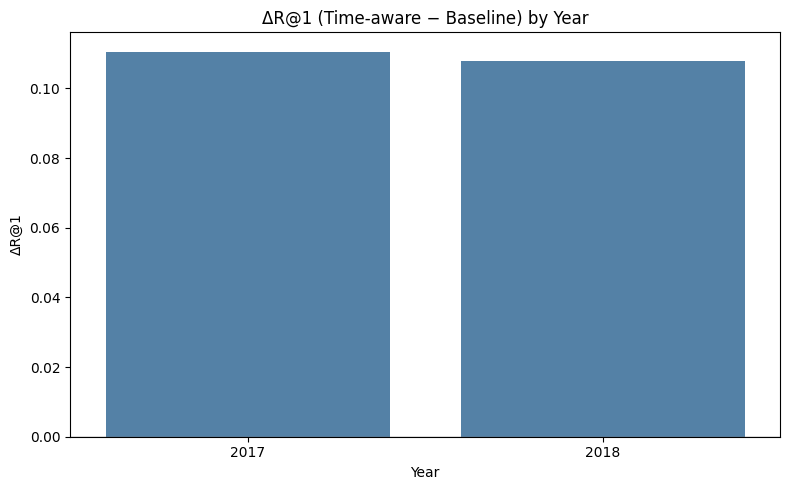

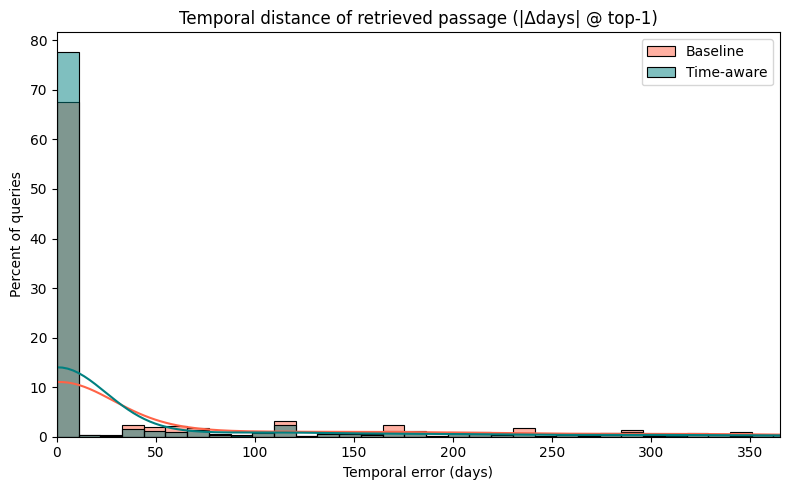

✅ Exported:
 - ccnews_results/summary.csv
 - ccnews_results/per_year.csv

=== Quick Summary ===
Overall ΔR@1 = +0.109 | ΔR@5 = +0.113 | ΔTC@1 = +0.005
Conflict-only ΔR@1 = +0.064
Temporal MAE improvement: 63.3 → 44.8 days (18.5 days closer)


In [ ]:
# === CC-News visualization & export ===
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from pathlib import Path

# 1. ΔR@1 per-year plot
plt.figure(figsize=(8,5))
sns.barplot(data=per_year_df, x="year", y="ΔR@1", color="steelblue")
plt.axhline(0, color="gray", lw=1)
plt.title("ΔR@1 (Time-aware − Baseline) by Year")
plt.ylabel("ΔR@1")
plt.xlabel("Year")
plt.tight_layout()
plt.show()

# 2. Temporal error histogram
plt.figure(figsize=(8,5))
sns.histplot(err_base, bins=50, color="tomato", label="Baseline", stat="percent", kde=True, alpha=0.5)
sns.histplot(err_time, bins=50, color="teal", label="Time-aware", stat="percent", kde=True, alpha=0.5)
plt.xlim(0, 365)
plt.xlabel("Temporal error (days)")
plt.ylabel("Percent of queries")
plt.title("Temporal distance of retrieved passage (|Δdays| @ top-1)")
plt.legend()
plt.tight_layout()
plt.show()

# 3. ΔR@1 vs ΔR@5 summary table
summary = {
    "R@1_base": m_base[0], "R@1_time": m_time[0], "ΔR@1": m_time[0]-m_base[0],
    "R@5_base": m_base[1], "R@5_time": m_time[1], "ΔR@5": m_time[1]-m_base[1],
    "TC@1_base": m_base[2], "TC@1_time": m_time[2], "ΔTC@1": m_time[2]-m_base[2],
    "Conflict_R@1_base": 0.539, "Conflict_R@1_time": 0.603, "Conflict_ΔR@1": 0.064,
    "MAE_base_days": np.mean(err_base), "MAE_time_days": np.mean(err_time),
    "MedianAE_base_days": np.median(err_base), "MedianAE_time_days": np.median(err_time),
    "N_passages": len(cc_df), "N_queries": len(Q_texts)
}
summary_df = pd.DataFrame([summary])

# 4. Export everything
out_dir = Path("ccnews_results")
out_dir.mkdir(exist_ok=True)
summary_df.to_csv(out_dir / "summary.csv", index=False)
per_year_df.to_csv(out_dir / "per_year.csv", index=False)

print("✅ Exported:")
print(f" - {out_dir/'summary.csv'}")
print(f" - {out_dir/'per_year.csv'}")

# Quick text summary
print("\n=== Quick Summary ===")
print(f"Overall ΔR@1 = {summary['ΔR@1']:+.3f} | ΔR@5 = {summary['ΔR@5']:+.3f} | ΔTC@1 = {summary['ΔTC@1']:+.3f}")
print(f"Conflict-only ΔR@1 = {summary['Conflict_ΔR@1']:+.3f}")
print(f"Temporal MAE improvement: {summary['MAE_base_days']:.1f} → {summary['MAE_time_days']:.1f} days "
      f"({summary['MAE_base_days']-summary['MAE_time_days']:.1f} days closer)")
